In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

To get everything in a notebook.

In [2]:
from fastai.everything import *

In [3]:
PATH = Path('../../data/cifar10/')
torch.backends.cudnn.benchmark = True

Model definition

In [4]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func=func
        
    def forward(self, x): return self.func(x)

def ResizeBatch(*size): return Lambda(lambda x: x.view((-1,)+size))
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))
def PoolFlatten(): return nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten())

In [5]:
def conv_2d(ni, nf, ks, stride): return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn(ni, init_zero=False):
    m = nn.BatchNorm2d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv_2d(ni, nf, ks, stride))

def noop(x): return x

class BasicBlock(nn.Module):
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv_2d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)


def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet(nn.Module):
    def __init__(self, num_groups, N, num_classes, k=1, drop_p=0.0, start_nf=16):
        super().__init__()
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)

        layers = [conv_2d(3, n_channels[0], 3, 1)]  # conv1
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], BasicBlock, (1 if i==0 else 2), drop_p)

        layers += [nn.BatchNorm2d(n_channels[3]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
                   Flatten(), nn.Linear(n_channels[3], num_classes)]
        self.features = nn.Sequential(*layers)

    def forward(self, x): return self.features(x)


def wrn_22(): return WideResNet(num_groups=3, N=3, num_classes=10, k=6, drop_p=0.)

In [6]:
model = wrn_22()

This is the way to create datasets in fastai_v1

In [7]:
train_ds = FilesDataset.from_folder(PATH/'train')
valid_ds = FilesDataset.from_folder(PATH/'test')

Data aug for now

In [8]:
from nb_003b import pad_tfm, crop_tfm, flip_lr_tfm, normalize_tfm, apply_tfms

In [9]:
data_mean,data_std = map(tensor, ([0.4914, 0.48216, 0.44653], [0.24703, 0.24349, 0.26159]))

In [10]:
train_tfms = [pad_tfm(padding=4), 
              crop_tfm(size=32, row_pct=(0,1), col_pct=(0,1)), 
              flip_lr_tfm(p=0.5), 
              normalize_tfm(mean=data_mean, std=data_std)]
valid_tfms = [normalize_tfm(mean=data_mean, std=data_std)]

In [11]:
from fastai.everything import *

In [12]:
class TfmDataset(Dataset):
    def __init__(self, ds: Dataset, tfms: Collection[Callable] = None, **kwargs):
        self.ds,self.tfms,self.kwargs = ds,tfms,kwargs
        
    def __len__(self): return len(self.ds)
    def __getattr__(self, k): return getattr(self.ds, k)
#     def fns(self): return self.ds.fns
    
    def __getitem__(self,idx):
        if isinstance(idx, tuple): idx,xtra = idx
        else: xtra={}
        x,y = self.ds[idx]
        return apply_tfms(self.tfms)(x, **self.kwargs, **xtra), y

In [13]:
train_tds = TfmDataset(train_ds, train_tfms)
valid_tds = TfmDataset(valid_ds, valid_tfms)
data = DataBunch(train_tds, valid_tds, bs=512, num_workers=8)

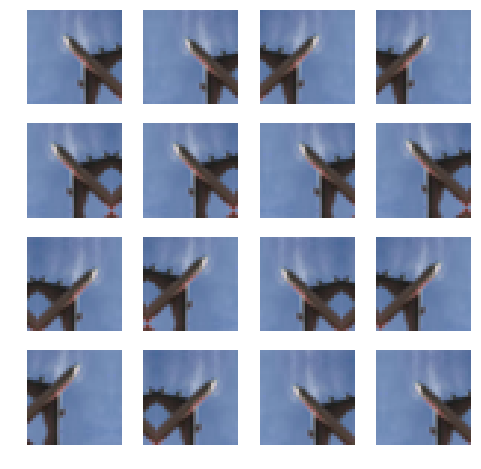

In [14]:
_,axs = plt.subplots(4,4,figsize=(8,8))
for i, ax in enumerate(axs.flatten()):
    img = train_tds[0][0] * data_std[:,None,None] + data_mean[:,None,None]
    ax.imshow(img.numpy().transpose(1,2,0))
    ax.axis('off')

A learner wraps together the data and the model, like in fastai. Here we test the usual training to 94% accuracy with AdamW.

In [15]:
model = wrn_22()
learn = Learner(data, model)
learn.metrics = [accuracy]
learn.true_wd = True
learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))

warm up

In [16]:
fit_one_cycle(learn, 3e-3, 1, wd=0.4)

<Figure size 432x288 with 0 Axes>

## FP16

The same but in mixed-precision.

In [22]:
model = wrn_22()
learn = Learner(data, model)
learn.metrics = [accuracy]
learn.true_wd = True
learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))
to_fp16(learn)

In [23]:
%time fit_one_cycle(learn, 3e-3, 30, wd=0.2)

CPU times: user 4min 58s, sys: 1min 43s, total: 6min 42s
Wall time: 7min 39s


<Figure size 432x288 with 0 Axes>